Deep Learning
=============

Assignment 1
------------

The objective of this assignment is to learn about simple data curation practices, and familiarize you with some of the data we'll be reusing later.

This notebook uses the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset to be used with python experiments. This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

In [8]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labelled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [3]:
url = 'http://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 1% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  if force or not os.path.exists(filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

#MMS: Lo cambio por los archivos de verdad ya descargados
#train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
#test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

def check_filename(filename,expected_bytes):
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified', filename)

train_filename = "notMNIST_large.tar.gz"
test_filename = "notMNIST_small.tar.gz"

check_filename(train_filename,247336696)
check_filename(test_filename,8458043)

Found and verified notMNIST_large.tar.gz
Found and verified notMNIST_small.tar.gz


Extract the dataset from the compressed .tar.gz file.
This should give you a set of directories, labelled A through J.

In [4]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders

#MMS: Lo cambio por los archivos de verdad ya descomprimidos
#train_folders = maybe_extract(train_filename)
#test_folders = maybe_extract(test_filename)

def list_subfolders(root,expected_folders):
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != expected_folders:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        expected_folders, len(data_folders)))
  print(data_folders)
  return data_folders

train_folders = list_subfolders("notMNIST_large",num_classes)
test_folders = list_subfolders("notMNIST_small",num_classes)

['notMNIST_large/A', 'notMNIST_large/B', 'notMNIST_large/C', 'notMNIST_large/D', 'notMNIST_large/E', 'notMNIST_large/F', 'notMNIST_large/G', 'notMNIST_large/H', 'notMNIST_large/I', 'notMNIST_large/J']
['notMNIST_small/A', 'notMNIST_small/B', 'notMNIST_small/C', 'notMNIST_small/D', 'notMNIST_small/E', 'notMNIST_small/F', 'notMNIST_small/G', 'notMNIST_small/H', 'notMNIST_small/I', 'notMNIST_small/J']


---
Problem 1
---------

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

---

In [49]:
def sneak_peek(folders_list):
    for d in folders_list:
        #print(d)
        #f = os.path.join(d, os.listdir(d)[0])
        f = str(d+"/"+os.listdir(d)[0])
        print(f)
        display(Image(f))

print("TRAIN")
sneak_peek(train_folders)
print ("TEST")
sneak_peek(test_folders)

TRAIN
notMNIST_large/A/a29ydW5pc2hpLnR0Zg==.png


notMNIST_large/B/a2F6b28udHRm.png


notMNIST_large/C/a29ydW5pc2hpLnR0Zg==.png


notMNIST_large/D/a29ydW5pc2hpLnR0Zg==.png


notMNIST_large/E/a29ydW5pc2hpLnR0Zg==.png


notMNIST_large/F/a29ydW5pc2hpLnR0Zg==.png


notMNIST_large/G/a29ydW5pc2hpLnR0Zg==.png


notMNIST_large/H/a29ydW5pc2hpLnR0Zg==.png


notMNIST_large/I/a29ydW5pc2hpLnR0Zg==.png


notMNIST_large/J/a29ydW5pc2hpLnR0Zg==.png


TEST
notMNIST_small/A/MDEtMDEtMDAudHRm.png


notMNIST_small/B/MDEtMDEtMDAudHRm.png


notMNIST_small/C/MDEtMDEtMDAudHRm.png


notMNIST_small/D/MDEtMDEtMDAudHRm.png


notMNIST_small/E/MDEtMDEtMDAudHRm.png


notMNIST_small/F/MDEtMDEtMDAudHRm.png


notMNIST_small/G/MDEtMDEtMDAudHRm.png


notMNIST_small/H/MDEtMDEtMDAudHRm.png


notMNIST_small/I/MDEtMDEtMDAudHRm.png


notMNIST_small/J/MDEtMDEtMDAudHRm.png


Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. 

A few images might not be readable, we'll just skip them.

In [18]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

#Ya los tengo hechos
#train_datasets = maybe_pickle(train_folders, 45000)
#test_datasets = maybe_pickle(test_folders, 1800)

Pickling notMNIST_large/A.pickle.
notMNIST_large/A
Could not read: notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png : cannot identify image file 'notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png' - it's ok, skipping.
Could not read: notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png : cannot identify image file 'notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png' - it's ok, skipping.
Could not read: notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png : cannot identify image file 'notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png' - it's ok, skipping.
Full dataset tensor: (52909, 28, 28)
Mean: -0.12825
Standard deviation: 0.443121
Pickling notMNIST_large/B.pickle.
notMNIST_large/B
Could not read: notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png : cannot identify image file 'notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png' - it's ok, skipping.
Full dataset tensor: (52911, 28, 28)
Mean: -0.00756303
Standard deviation: 0.454491
Pickling notMNIST_large/C.pic

---
Problem 2
---------

Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

---

In [34]:
#Ver datos preprocesados
def show_onepickleimage(letter,image_id,basedir):
    set_filename = basedir+"/"+letter+".pickle"
    try:
        with open(set_filename, 'rb') as f:
          ds = pickle.load(f) #np.ndarray(id,x,y,normalized_grayscale)
    except Exception as e:
        print('Unable to load data from', set_filename, ':', e)
        raise
    
    arr = np.squeeze(ds[image_id,:,:])
    plt.imshow(arr, cmap='gray')
    plt.show()

def show_onetrain(letter,image_id):
    show_onepickleimage(letter,image_id,'notMNIST_large')

def show_onetest(letter,image_id):
    show_onepickleimage(letter,image_id,'notMNIST_small')


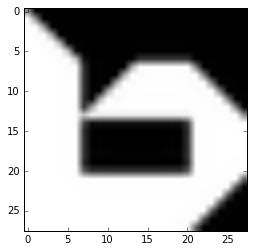

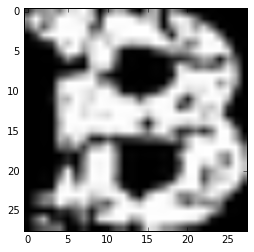

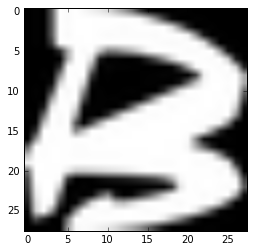

In [35]:
#Ver train
show_onetrain('A',7777)
show_onetrain('B',0)
show_onetrain('B',10)
show_onetrain('B',1230)


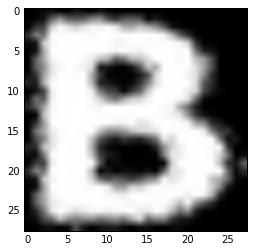

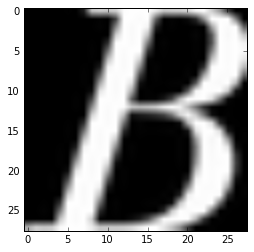

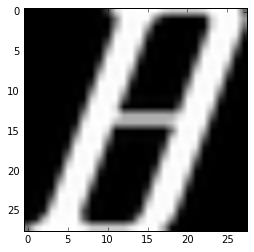

In [36]:
#Ver test
show_onetest('B',0)
show_onetest('B',10)
show_onetest('B',1230)


---
Problem 3
---------
Another check: we expect the data to be balanced across classes. Verify that.

---

In [50]:
print(train_datasets)
print(test_datasets)

['notMNIST_large/A.pickle', 'notMNIST_large/B.pickle', 'notMNIST_large/C.pickle', 'notMNIST_large/D.pickle', 'notMNIST_large/E.pickle', 'notMNIST_large/F.pickle', 'notMNIST_large/G.pickle', 'notMNIST_large/H.pickle', 'notMNIST_large/I.pickle', 'notMNIST_large/J.pickle']
['notMNIST_small/A.pickle', 'notMNIST_small/B.pickle', 'notMNIST_small/C.pickle', 'notMNIST_small/D.pickle', 'notMNIST_small/E.pickle', 'notMNIST_small/F.pickle', 'notMNIST_small/G.pickle', 'notMNIST_small/H.pickle', 'notMNIST_small/I.pickle', 'notMNIST_small/J.pickle']


In [60]:
#Ver datos preprocesados
def show_picklesize(set_filename):
    try:
        with open(set_filename, 'rb') as f:
          ds = pickle.load(f) #np.ndarray(id,x,y,normalized_grayscale)
    except Exception as e:
        print('Unable to load data from', set_filename, ':', e)
        raise
    
    print(set_filename+" size: "+str(ds.size)+" shape: "+str(ds.shape))


In [61]:
for d in train_datasets:
    show_picklesize(d)

notMNIST_large/A.pickle size: 41480656 shape: (52909, 28, 28)
notMNIST_large/B.pickle size: 41482224 shape: (52911, 28, 28)
notMNIST_large/C.pickle size: 41483008 shape: (52912, 28, 28)
notMNIST_large/D.pickle size: 41482224 shape: (52911, 28, 28)
notMNIST_large/E.pickle size: 41483008 shape: (52912, 28, 28)
notMNIST_large/F.pickle size: 41483008 shape: (52912, 28, 28)
notMNIST_large/G.pickle size: 41483008 shape: (52912, 28, 28)
notMNIST_large/H.pickle size: 41483008 shape: (52912, 28, 28)
notMNIST_large/I.pickle size: 41483008 shape: (52912, 28, 28)
notMNIST_large/J.pickle size: 41482224 shape: (52911, 28, 28)


In [62]:
for d in test_datasets:
    show_picklesize(d)

notMNIST_small/A.pickle size: 1467648 shape: (1872, 28, 28)
notMNIST_small/B.pickle size: 1468432 shape: (1873, 28, 28)
notMNIST_small/C.pickle size: 1468432 shape: (1873, 28, 28)
notMNIST_small/D.pickle size: 1468432 shape: (1873, 28, 28)
notMNIST_small/E.pickle size: 1468432 shape: (1873, 28, 28)
notMNIST_small/F.pickle size: 1467648 shape: (1872, 28, 28)
notMNIST_small/G.pickle size: 1467648 shape: (1872, 28, 28)
notMNIST_small/H.pickle size: 1467648 shape: (1872, 28, 28)
notMNIST_small/I.pickle size: 1467648 shape: (1872, 28, 28)
notMNIST_small/J.pickle size: 1467648 shape: (1872, 28, 28)


Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune `train_size` as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

In [63]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [64]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

---
Problem 4
---------
Convince yourself that the data is still good after shuffling!

---

In [88]:
def label_to_letter(label):
    if (label == 0):
        return 'A'
    if (label == 1):
        return 'B'
    if (label == 2):
        return 'C'
    if (label == 3):
        return 'D'
    if (label == 4):
        return 'E'
    if (label == 5):
        return 'F'
    if (label == 6):
        return 'G'
    if (label == 7):
        return 'H'
    if (label == 8):
        return 'I'
    if (label == 9):
        return 'J'

def show_letter(ds_label,ds_data,position):
    print(label_to_letter(ds_label[position]))
    arr = np.squeeze(ds_data[position,:,:])
    ax = plt.imshow(arr, cmap='gray')
    F = ax.get_figure()
    #plt.show()   
    #F = gcf()
    Size = F.get_size_inches()
    F.set_size_inches(Size[0]/6, Size[1]/6, forward=True)#Set forward to True to resize window along with plot in figure.
    plt.show()

H


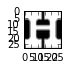

C


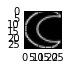

J


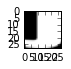

H


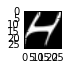

B


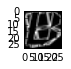

F


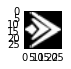

D


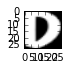

J


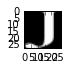

A


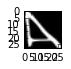

D


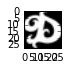

In [89]:
#Algunas posiciones
pos = [3,9000,567,2478,9999]

for i in pos:
    show_letter(test_labels,test_dataset,i)
    show_letter(train_labels,train_dataset,i)


Finally, let's save the data for later reuse:

In [90]:
pickle_file = 'notMNIST.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [91]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800441


---
Problem 5
---------

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it.
Measure how much overlap there is between training, validation and test samples.

Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
---

In [103]:
def cartesian(arrays, out=None):
    """
    Generate a cartesian product of input arrays.

    Parameters
    ----------
    arrays : list of array-like
        1-D arrays to form the cartesian product of.
    out : ndarray
        Array to place the cartesian product in.

    Returns
    -------
    out : ndarray
        2-D array of shape (M, len(arrays)) containing cartesian products
        formed of input arrays.

    Examples
    --------
    >>> cartesian(([1, 2, 3], [4, 5], [6, 7]))
    array([[1, 4, 6],
           [1, 4, 7],
           [1, 5, 6],
           [1, 5, 7],
           [2, 4, 6],
           [2, 4, 7],
           [2, 5, 6],
           [2, 5, 7],
           [3, 4, 6],
           [3, 4, 7],
           [3, 5, 6],
           [3, 5, 7]])

    """

    arrays = [np.asarray(x) for x in arrays]
    dtype = arrays[0].dtype

    n = np.prod([x.size for x in arrays])
    if out is None:
        out = np.zeros([n, len(arrays)], dtype=dtype)

    m = n / arrays[0].size
    out[:,0] = np.repeat(arrays[0], m)
    if arrays[1:]:
        cartesian(arrays[1:], out=out[0:m,1:])
        for j in xrange(1, arrays[0].size):
            out[j*m:(j+1)*m,1:] = out[0:m,1:]
    return out

In [114]:
cartesian(([1, 2, 3], [1, 2, 3]))

array([[1, 1],
       [1, 2],
       [1, 3],
       [2, 1],
       [2, 2],
       [2, 3],
       [3, 1],
       [3, 2],
       [3, 3]])

In [181]:
#Letra por letra, porque solo estaran repetidos dentro de la misma letra
def get_duplicates(ds,ls,limit=None):
    dup = []
    for L in range(0,10):
        print("check letter "+label_to_letter(L))
        ind = np.where(ls == L)
        if (limit != None):
            pos = ind[0][0:limit]
        else:
            pos = ind[0]
        #print(pos)
        #sds = ds[pos,:,:].copy()
        #print(sds.shape)
        for i,pos1 in enumerate(pos):
            for j,pos2 in enumerate(pos):
                if(j > i):
                    #print(str(pos1)+" "+str(pos2))
                    if (np.array_equal(ds[pos1,:,:],ds[pos2,:,:]) == True):
                        #print ("duplicated indexes = "+str(pos1)+" and "+str(pos2))
                        dup.append([pos1,pos2])
    out = np.asarray(dup)
    #print(out.shape)
    return out

In [183]:
#Test internos
test_dup = get_duplicates(test_dataset,test_labels)
print(test_dup.shape)
#print(test_dup)

check letter A
check letter B
check letter C
check letter D
check letter E
check letter F
check letter G
check letter H
check letter I
check letter J
(9945, 2)


In [189]:
#print(test_dup[0:10])
#show_letter(test_labels,test_dataset,1106)
#show_letter(test_labels,test_dataset,3881)

In [190]:
#Valid internos
valid_dup = get_duplicates(valid_dataset,valid_labels)
print(valid_dup.shape)

check letter A
check letter B
check letter C
check letter D
check letter E
check letter F
check letter G
check letter H
check letter I
check letter J
(4303, 2)


In [191]:
#Train internos
train_dup = get_duplicates(train_dataset,train_labels)
print(train_dup.shape)

check letter A
check letter B
check letter C
check letter D
check letter E
check letter F
check letter G
check letter H
check letter I
check letter J
(2286413, 2)


In [192]:
#Guardo la lista de duplicados internos por si acaso lo necesitara luego
pickle_file = 'notMNIST.duplicates.ind.pickle'
try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dup': train_dup,
    'valid_dup': valid_dup,
    'test_dup': test_dup,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [194]:
#Prueba de recuperacion
pickle_file = 'notMNIST.duplicates.ind.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  a = save['train_dup']
  b = save['valid_dup']
  c = save['test_dup']
  del save  # hint to help gc free up memory
  print('test_dup', test_dup.shape, test_dup)
  print('c', c.shape, c)


test_dup (9945, 2) [[ 554 6761]
 [1106 3881]
 [1129 1353]
 ..., 
 [1626 7836]
 [2612 2903]
 [4547 6205]]
c (9945, 2) [[ 554 6761]
 [1106 3881]
 [1129 1353]
 ..., 
 [1626 7836]
 [2612 2903]
 [4547 6205]]


In [195]:
#Ver duplicados cruzados entre dos datasets
#Letra por letra, porque solo estaran repetidos dentro de la misma letra
def get_crossduplicates(ds1,ls1,ds2,ls2,limit=None):
    dup = []
    for L in range(0,10):
        print("check letter "+label_to_letter(L))
        ind1 = np.where(ls1 == L)
        ind2 = np.where(ls2 == L)
        if (limit != None):
            pos1 = ind1[0][0:limit]
            pos2 = ind2[0][0:limit]
        else:
            pos1 = ind1[0]
            pos2 = ind2[0]
        #sds1 = ds1[pos1,:,:].copy()
        #sds2 = ds2[pos2,:,:].copy()
        #print(sds1.shape)
        #print(sds2.shape)
        for i,p1 in enumerate(pos1):
            for j,p2 in enumerate(pos2):
                    #print(str(p1)+" "+str(p2))
                    if (np.array_equal(ds1[p1,:,:],ds2[p2,:,:]) == True):
                        #print ("duplicated indexes = "+str(p1)+" and "+str(p2))
                        dup.append([p1,p2])
    out = np.asarray(dup)
    #print(out.shape)
    return out

In [196]:
#Cruzados test-train EXPERIMENTOS
test_train_dup = get_crossduplicates(test_dataset,test_labels,train_dataset,train_labels,limit=100)
print(test_train_dup.shape)
print(test_train_dup)

check letter A
check letter B
check letter C
check letter D
check letter E
check letter F
check letter G
check letter H
check letter I
check letter J
(146, 2)
[[162 158]
 [461 717]
 [200  43]
 [125 128]
 [125 235]
 [125 242]
 [125 290]
 [125 303]
 [125 490]
 [125 522]
 [125 623]
 [125 634]
 [125 668]
 [125 669]
 [155 128]
 [155 235]
 [155 242]
 [155 290]
 [155 303]
 [155 490]
 [155 522]
 [155 623]
 [155 634]
 [155 668]
 [155 669]
 [373 128]
 [373 235]
 [373 242]
 [373 290]
 [373 303]
 [373 490]
 [373 522]
 [373 623]
 [373 634]
 [373 668]
 [373 669]
 [383 128]
 [383 235]
 [383 242]
 [383 290]
 [383 303]
 [383 490]
 [383 522]
 [383 623]
 [383 634]
 [383 668]
 [383 669]
 [393 128]
 [393 235]
 [393 242]
 [393 290]
 [393 303]
 [393 490]
 [393 522]
 [393 623]
 [393 634]
 [393 668]
 [393 669]
 [407 128]
 [407 235]
 [407 242]
 [407 290]
 [407 303]
 [407 490]
 [407 522]
 [407 623]
 [407 634]
 [407 668]
 [407 669]
 [640 128]
 [640 235]
 [640 242]
 [640 290]
 [640 303]
 [640 490]
 [640 522]
 [640

B


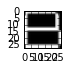

B


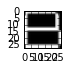

In [197]:
show_letter(test_labels,test_dataset,461)
show_letter(train_labels,train_dataset,717)

In [198]:
#Cruzados test-train
test_train_dup = get_crossduplicates(test_dataset,test_labels,train_dataset,train_labels)
print(test_train_dup.shape)

check letter A
check letter B
check letter C
check letter D
check letter E
check letter F
check letter G
check letter H
check letter I
check letter J
(302240, 2)


In [199]:
#Cruzados valid-train
valid_train_dup = get_crossduplicates(valid_dataset,valid_labels,train_dataset,train_labels)
print(valid_train_dup.shape)

check letter A
check letter B
check letter C
check letter D
check letter E
check letter F
check letter G
check letter H
check letter I
check letter J
(199591, 2)


In [200]:
#Guardo la lista de duplicados cruzados por si acaso

pickle_file = 'notMNIST.crossduplicates.ind.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'test_train_dup': test_train_dup,
    'valid_train_dup': valid_train_dup,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [227]:
#Eliminar duplicados cruzados de test y valid y guardar datos limpios para luego

print("TEST")
dind = np.asarray(np.unique(test_train_dup.T[0]))
test_clean_dataset = np.delete(test_dataset,dind,axis=0)
test_clean_labels = np.delete(test_labels,dind,axis=0)
print(dind.shape)
print(test_dataset.shape)
print(test_clean_dataset.shape)
print(test_clean_labels.shape)

print("VALID")
dind = np.asarray(np.unique(valid_train_dup.T[0]))
valid_clean_dataset = np.delete(valid_dataset,dind,axis=0)
valid_clean_labels = np.delete(valid_labels,dind,axis=0)
print(dind.shape)
print(valid_dataset.shape)
print(valid_clean_dataset.shape)
print(valid_clean_labels.shape)

pickle_file = 'notMNIST.cleantestvalid.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'test_clean_dataset': test_clean_dataset,
    'test_clean_labels': test_clean_labels,
    'valid_clean_dataset': valid_clean_dataset,
    'valid_clean_labels': valid_clean_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

TEST
(1324,)
(10000, 28, 28)
(8676, 28, 28)
(8676,)
VALID
(1048,)
(10000, 28, 28)
(8952, 28, 28)
(8952,)


In [ ]:
#PENDIENTE DETECCION DE CUASI DUPLICADOS

---
Problem 6
---------

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

---

In [30]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


In [24]:
import time
def how_long(f, *args):
    #medir el tiempo que tarda f
    t1 = time.time()
    res = f(*args)
    t2 = time.time()
    print ("tiempo utilizado = ",t2-t1)
    #return res, t2-t1
    return res

In [31]:
#Crear un modelo, con los parámetros por defecto
nsamples, nx, ny = train_dataset.shape
X = train_dataset.reshape((nsamples,nx*ny))
Y = train_labels

logreg = LogisticRegression()

#Y otro autoajustable
logregCV = LogisticRegressionCV()

In [32]:
#Entrenarlos TARDA LO SUYO
how_long(logreg.fit, X, Y)

tiempo utilizado =  1773.45064306


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [33]:
how_long(logregCV.fit, X, Y)

tiempo utilizado =  3313.38123298


LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [34]:
#Ver que tal funcionan
# The coefficients
print('Coefficients: \n', logreg.coef_)
print('Coefficients CV: \n', logregCV.coef_)

Coefficients: 
 [[-1.06223069 -0.20650722 -0.30871461 ...,  0.22609959  0.7351643
   1.16836084]
 [ 0.0170128   0.17266581  0.11196635 ..., -0.80084128 -0.48212595
  -0.02020093]
 [ 0.49145552 -0.45174306 -0.10865645 ..., -0.10291425  0.26882044
   0.39569159]
 ..., 
 [-0.33275793  0.43260602  0.43363962 ...,  0.58470122  0.16276548
   0.03939654]
 [ 0.24771398 -0.0502138   0.15331767 ...,  0.54853501 -0.39311548
  -0.16082795]
 [-0.19181156  0.12232581 -0.49181249 ..., -0.51665481 -0.46792851
  -0.43873724]]
Coefficients CV: 
 [[-0.62682597 -0.39341426 -0.23740135 ...,  0.26516906  0.71470059
   0.90471576]
 [ 0.07873054  0.13736572  0.08720317 ..., -0.4181916  -0.46527213
  -0.10139973]
 [-0.08237881 -0.19422112 -0.16036199 ...,  0.05311337  0.1123144
   0.15879517]
 ..., 
 [-0.00153898  0.18442434  0.18744642 ...,  0.18369135  0.20274811
   0.07342643]
 [ 0.15928311  0.03479021  0.08421363 ...,  0.10940836 -0.10976016
   0.05036249]
 [-0.12515886 -0.0420525  -0.23524921 ..., -0.3594

In [35]:
nsamples, nx, ny = test_dataset.shape
X_test = test_dataset.reshape((nsamples,nx*ny))
Y_test = test_labels

# The mean squared error
print("Mean squared error: %.2f"
      % np.mean((logreg.predict(X_test) - Y_test) ** 2))
print("Mean squared error CV: %.2f"
      % np.mean((logregCV.predict(X_test) - Y_test) ** 2))

Mean squared error: 1.91
Mean squared error CV: 1.88


In [36]:
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % logreg.score(X_test, Y_test))
print('Variance score CV: %.2f' % logreg.score(X_test, Y_test))

Variance score: 0.89
Variance score CV: 0.89


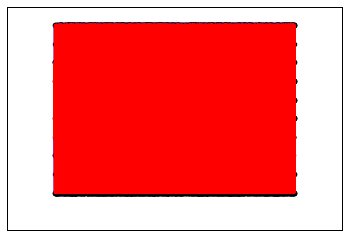

In [37]:
# Plot outputs
X_plot = np.arange(0,X_test.shape[0])

plt.scatter(X_plot, Y_test,  color='black')
plt.plot(X_plot, logreg.predict(X_test), color='blue',
         linewidth=3)
plt.plot(X_plot, logregCV.predict(X_test), color='red',
         linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

In [ ]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    #pass  # TODO: Compute and return softmax(x)
    return np.exp(x)/np.sum(np.exp(x),axis=0)

def distance(S,L):
    """Compute cross-entropy distance for one hot-encoded label"""
    return -1*np.sum(L*np.log(S))

def loss(D)
    """Compute loss for a vector of distances"""
    return np.sum(D)/np.len(D)
